# Predicting the Temperature in Canada

This notebook will introduce you to the basics of AI. This tutorial is inspired by this [Kaggle notebook](https://www.kaggle.com/code/eminacikgoz/predicting-temperature-in-turkey) and uses data from the [Berkely Earth Surface Temperature Dataset](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?resource=download).

## Step 1: Loading Packages

In [1]:
# Load packages
import numpy as np                    # For linear algebra
import pandas as pd                   # For data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns                 # For visualization
import matplotlib.pyplot as plt       # Data plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

!pip install adjustText
!pip install gdown
import gdown


## Step 2: Exploring our Data



In [2]:
gdown.download_folder('https://drive.google.com/drive/folders/1J-e1rrMFLt3ZBmUZgBn0ss8AZy8A8Dj7?usp=drive_link', quiet=True)

['/content/canada-temperature/canada-map.dbf',
 '/content/canada-temperature/canada-map.prj',
 '/content/canada-temperature/canada-map.shp',
 '/content/canada-temperature/canada-map.shx',
 '/content/canada-temperature/canada-map.xml',
 '/content/canada-temperature/GlobalLandTemperaturesByCity.csv']

In [3]:
# Read data from a csv file
city_df = pd.read_csv('/content/canada-temperature/GlobalLandTemperaturesByCity.csv')

# Choose cities where Country is Canada
city_df_can = city_df[city_df["Country"] == "Canada"]

city_df_can   # Shows a table of the data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
32382,1828-01-01,-2.763,2.617,Abbotsford,Canada,49.03N,122.45W
32383,1828-02-01,0.393,1.936,Abbotsford,Canada,49.03N,122.45W
32384,1828-03-01,4.137,1.910,Abbotsford,Canada,49.03N,122.45W
32385,1828-04-01,NaN,NaN,Abbotsford,Canada,49.03N,122.45W
32386,1828-05-01,10.630,2.346,Abbotsford,Canada,49.03N,122.45W
...,...,...,...,...,...,...,...
8226978,2013-05-01,10.280,0.518,Winnipeg,Canada,50.63N,97.61W
8226979,2013-06-01,17.123,0.401,Winnipeg,Canada,50.63N,97.61W
8226980,2013-07-01,18.685,0.237,Winnipeg,Canada,50.63N,97.61W
8226981,2013-08-01,18.620,0.600,Winnipeg,Canada,50.63N,97.61W


We can see that our data has 7 columns

* `dt` represents the date, formatted as YYYY-MM-DD.
* `AverageTemperature`: mean temperature for a given location (city) on the specified date, recorded in degrees Celsius (°C).
  * In some cases there is no temperature data, and this is represented by NaN (Not a Number).
* `AverageTemperatureUncertainty`: degree of error or the confidence interval for the temperature measurement. Essentially, it tells us how precise the temperature data is. The uncertainty is expressed in degrees Celsius (°C).
* `city`: the city where the temperature data was recorded.
* `country`: the country where the corresponding city is located.
  * Since we selected only cities in Canada, we will only see data from Canadian cities.
* `latitude`: a measure of how far a location is from the equator, given in degrees north or south.
  * Latitude ranges from 0° at the Equator to 90° North at the North Pole and 90° South at the South Pole.
  * Cities close to the equator tend to be warmer.
* `longitude`: a measure of how far a location is from the Prime Meridian, which is located at 0° longitude.
  * The range of longitude spans from 0° at the Prime Meridian to 180° East or West.
  * Like latitude, longitude helps to pinpoint a location on the globe and provides geographic context for temperature measurements.



---


Now, let's look at how many reading we have for each city. We are using `value_counts()` on the **City** column to count how many readings exist for each city in our dataset.

This helps us understand the **distribution of the data** and identify if certain cities have more data than others. By doing this, we can check for any data imbalances, such as cities with too few records, which could affect our analysis or lead to biased results.

In [4]:
city_df_can['City'].value_counts()

,count
City,
Barrie,3239
Kingston,3239
Guelph,3239
Hamilton,3239
Halifax,3239
Oshawa,3239
Montreal,3239
London,3239
Kitchener,3239


We use the line `city_df_can.duplicated().sum()` to check if there are any **duplicate rows** in our dataset. If the result is 0, as shown here, it means that there are no duplicate entries.



In [5]:
city_df_can.duplicated().sum()

np.int64(0)

Next, `city_df_can.isnull().sum()` helps us identify the number of **missing values** (nulls) in each column. This step is important because missing data can impact our analysis and modeling. By checking for null values, we can decide whether to impute, remove, or handle them in a way that ensures the quality of our dataset.

In [6]:
city_df_can.isnull().sum()

,0
dt,0
AverageTemperature,4001
AverageTemperatureUncertainty,4001
City,0
Country,0
Latitude,0
Longitude,0


`city_df_can.describe().T` generates **summary statistics** (like mean, min, max, and standard deviation) for each numeric column in the dataset. The `.T` transposes the output and makes it easier to read and compare statistics for each column.

In [7]:
city_df_can.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,71444.0,4.900387,10.433337,-31.825,-3.66725,5.599,14.29825,26.968
AverageTemperatureUncertainty,71444.0,1.215804,1.240398,0.064,0.30200,0.594,1.91000,9.493


We are using `find_coordinate_conflicts` to check for potential mistakes in the dataset, where multiple cities might be listed at the same coordinates. Identifying these conflicts help to make sure our location data is accourate.

In [8]:
def find_coordinate_conflicts(df):
    # Group by coordinates and check for multiple city names
    conflicts = []
    coord_groups = df.groupby(['Latitude', 'Longitude'])

    # Find groups with more than one unique city name
    for (lat, lon), group in coord_groups:
        if group['City'].nunique() > 1:
            # Get unique city names
            city_names = group['City'].unique()

            # Generate all unique pairs of cities
            for i in range(len(city_names)):
                for j in range(i+1, len(city_names)):
                    # Sort to avoid duplicate prints
                    conflict_pair = tuple(sorted([city_names[i], city_names[j]]))
                    if conflict_pair not in conflicts:
                        conflicts.append(conflict_pair)
                        print(f"{conflict_pair[0]} {conflict_pair[1]}")

    return conflicts


# Run the test
coordinate_conflicts = find_coordinate_conflicts(city_df_can)

# Additional summary
print("\nTotal number of coordinate conflicts:", len(coordinate_conflicts))

Hamilton London
Barrie Guelph
Barrie Kitchener
Barrie Toronto
Barrie Waterloo
Guelph Kitchener
Guelph Toronto
Guelph Waterloo
Kitchener Toronto
Kitchener Waterloo
Toronto Waterloo
Montreal Sherbrooke
Montreal Trois Rivières
Sherbrooke Trois Rivières
Abbotsford Vancouver
Abbotsford Victoria
Vancouver Victoria

Total number of coordinate conflicts: 17


In [9]:
def find_and_remove_coordinate_conflicts(df):
    # Group by coordinates and check for multiple city names
    conflicts = []
    coord_groups = df.groupby(['Latitude', 'Longitude'])

    # List to hold indices of rows to remove
    rows_to_remove = set()

    # Find groups with more than one unique city name
    for (lat, lon), group in coord_groups:
        if group['City'].nunique() > 1:
            # Get unique city names
            city_names = group['City'].unique()

            # Generate all unique pairs of cities
            for i in range(len(city_names)):
                for j in range(i+1, len(city_names)):
                    # Sort to avoid duplicate prints
                    conflict_pair = tuple(sorted([city_names[i], city_names[j]]))
                    if conflict_pair not in conflicts:
                        conflicts.append(conflict_pair)
                        print(f"Conflict: {conflict_pair[0]} and {conflict_pair[1]} at coordinates ({lat}, {lon})")

            # Add the indices of the conflicting rows to the rows_to_remove set
            rows_to_remove.update(group.index)

    # Remove rows with conflicts
    df_cleaned = df.drop(rows_to_remove)

    return df_cleaned, conflicts

city_df_can, conflicts = find_and_remove_coordinate_conflicts(city_df_can)

Conflict: Hamilton and London at coordinates (42.59N, 80.73W)
Conflict: Barrie and Guelph at coordinates (44.20N, 80.50W)
Conflict: Barrie and Kitchener at coordinates (44.20N, 80.50W)
Conflict: Barrie and Toronto at coordinates (44.20N, 80.50W)
Conflict: Barrie and Waterloo at coordinates (44.20N, 80.50W)
Conflict: Guelph and Kitchener at coordinates (44.20N, 80.50W)
Conflict: Guelph and Toronto at coordinates (44.20N, 80.50W)
Conflict: Guelph and Waterloo at coordinates (44.20N, 80.50W)
Conflict: Kitchener and Toronto at coordinates (44.20N, 80.50W)
Conflict: Kitchener and Waterloo at coordinates (44.20N, 80.50W)
Conflict: Toronto and Waterloo at coordinates (44.20N, 80.50W)
Conflict: Montreal and Sherbrooke at coordinates (45.81N, 72.69W)
Conflict: Montreal and Trois Rivières at coordinates (45.81N, 72.69W)
Conflict: Sherbrooke and Trois Rivières at coordinates (45.81N, 72.69W)
Conflict: Abbotsford and Vancouver at coordinates (49.03N, 122.45W)
Conflict: Abbotsford and Victoria at c

### Visualizing the Data

First, we'll visualize the average temperatures of 10 randomly sampled Canadian cities.

There are 3 mains steps:
1. Process the coordinates to make sure they are properly formatted when we make our plots.
2. Randomly sample 10 Canadian cities.
3. Plot the average temperature, latitude, and longitude.

In [10]:
import geopandas as gpd

def format_coordinates(coord):
    # Handle numeric values
    if isinstance(coord, (int, float)):
        return float(coord)

    # If it's a string, process it
    if isinstance(coord, str):
        # Remove any whitespace
        coord = coord.strip()

        # Determine sign based on direction
        if coord.endswith(('N', 'E')):
                   sign = 1
                   coord = coord[:-1]
        elif coord.endswith(('S', 'W')):
            sign = -1
            coord = coord[:-1]
        else:
            sign = 1

        # Convert to float
        return sign * float(coord)

    # If it's something unexpected, return as is or raise an error
    return coord

# Format the coordinates
city_df_can.loc[:, 'Latitude'] = city_df_can['Latitude'].apply(format_coordinates)
city_df_can.loc[:, 'Longitude'] = city_df_can['Longitude'].apply(format_coordinates)

In [11]:
# Sample 10 cities, making sure there are no duplicates
city_df_can_unique = city_df_can.drop_duplicates(subset='City')
sampled_cities = city_df_can_unique.sample(n=10, random_state=46)

# Create a Geopandas GeoDataFrame for plotting
gdf_cities = gpd.GeoDataFrame(sampled_cities,
                               geometry=gpd.points_from_xy(sampled_cities['Longitude'],
                                                          sampled_cities['Latitude']))

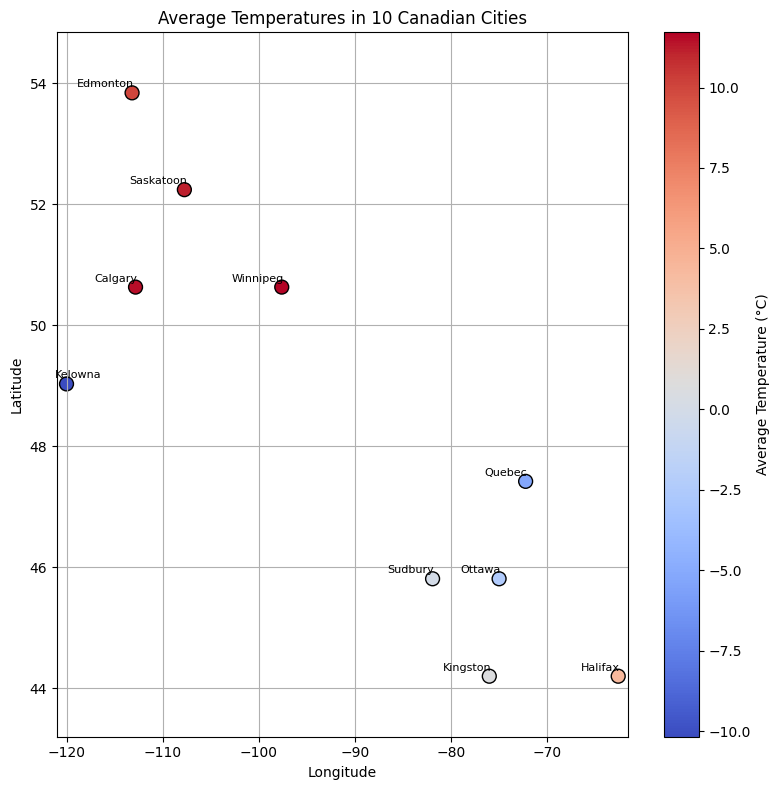

              City  AverageTemperature Latitude Longitude
6161149     Quebec              -5.240    47.42    -72.24
2166330   Edmonton              10.008    53.84   -113.18
1304443    Calgary              11.472    50.63   -112.82
5549558     Ottawa              -2.460    45.81     -75.0
6798257  Saskatoon              11.137    52.24   -107.74
8224042   Winnipeg              11.716    50.63    -97.61
7202979    Sudbury              -0.060    45.81    -81.92
2823526    Halifax               4.436     44.2    -62.61
3734875    Kelowna             -10.176    49.03    -120.0
3834476   Kingston               0.628     44.2    -76.02


In [12]:
from adjustText import adjust_text

# Plot the cities with colors based on average temperatures
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of cities, with color representing temperature
scatter = ax.scatter(sampled_cities['Longitude'], sampled_cities['Latitude'],
                     c=sampled_cities['AverageTemperature'], cmap='coolwarm',
                     s=100, edgecolor='black')

# Get the min and max for latitude and longitude from the sampled cities
lat_min = sampled_cities['Latitude'].min()
lat_max = sampled_cities['Latitude'].max()
lon_min = sampled_cities['Longitude'].min()
lon_max = sampled_cities['Longitude'].max()

# Set map limits based on the sampled cities coordinates
ax.set_xlim([lon_min - 1, lon_max + 1])  # Adding buffer for better visibility
ax.set_ylim([lat_min - 1, lat_max + 1])  # Adding buffer for better visibility

# Annotate each city
texts = []
for i, row in sampled_cities.iterrows():
    texts.append(ax.text(row['Longitude'], row['Latitude'], row['City'],
                         fontsize=8, ha='right', va='bottom'))

# Adjust text to avoid overlap
# adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'},
#             arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))
adjust_text(
    texts,
    only_move={'points': 'xy', 'text': 'xy'},  # Only move the points and text along the x and y axes
    expand_points=(1.5, 1.5),  # Slightly expand the points' range to prevent text collisions
    expand_text=(1.5, 1.5),  # Allow text to expand a bit beyond its original position
    lim=100  # Limit the number of iterations for performance
)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Average Temperature (°C)')

ax.set_title('Average Temperatures in 10 Canadian Cities')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the sampled cities for reference
print(sampled_cities[['City', 'AverageTemperature', 'Latitude', 'Longitude']])

---
We can also visualize the cities on a map!

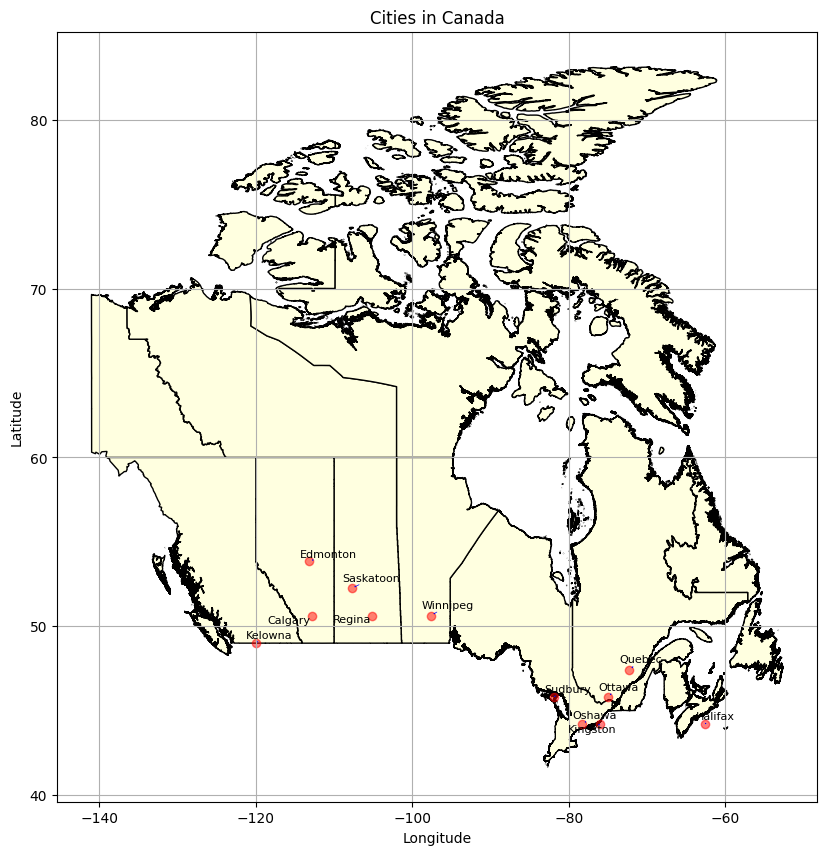

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from adjustText import adjust_text

# Remove duplicates based on the 'City' column
cities_unique = city_df_can.drop_duplicates(subset='City')
cities_unique

# Create a GeoDataFrame for plotting cities
geometry = [Point(lon, lat) for lon, lat in zip(cities_unique['Longitude'], cities_unique['Latitude'])]
gdf_cities = gpd.GeoDataFrame(cities_unique, geometry=geometry)

# Load the world shapefile (Canada map)
canada = gpd.read_file('/content/canada-temperature/canada-map.shp')

# Reproject the shapefile to match the cities' coordinates (EPSG:4326)
gdf = canada.to_crs(epsg=4326)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Set aspect ratio to 'equal' for proper map scaling
ax.set_aspect('equal')

# Plot the shapefile (Canada map)
gdf.plot(ax=ax, color='lightyellow', edgecolor='black')

# Plot the cities on top of the map
ax.scatter(cities_unique['Longitude'], cities_unique['Latitude'], c='red', label='Cities', alpha=0.5)

# Create labels for cities
texts = []
for i, row in cities_unique.iterrows():
    text = ax.text(row['Longitude'], row['Latitude'], row['City'], fontsize=8, ha='right', va='bottom')
    texts.append(text)

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='blue', lw=0.5))

# Set map title and axis labels
ax.set_title('Cities in Canada')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add gridlines
plt.grid(True)

# Show plot
plt.show()

Now, lets plot the average temperature of cities over time.


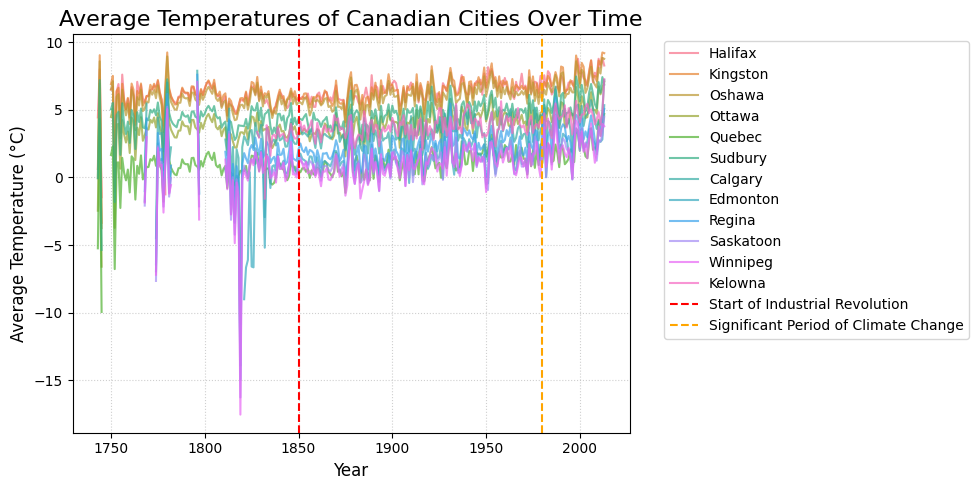

In [14]:
# Prepare the data
def prepare_temperature_data(city_df_can):
    # Convert Date column to datetime
    city_df_can['dt'] = pd.to_datetime(city_df_can['dt'])

    # Group by Date and City, taking the mean temperature
    grouped_temps = city_df_can.groupby([city_df_can['dt'].dt.year, 'City'])['AverageTemperature'].mean().reset_index()
    grouped_temps.columns = ['Year', 'City', 'AvgTemperature']

    return grouped_temps

def plot_city_temperatures(grouped_temps):
    plt.figure(figsize=(10, 5))

    # Create a color palette for unique cities
    unique_cities = grouped_temps['City'].unique()
    color_palette = sns.color_palette("husl", len(unique_cities))

    # Plot each city's temperature over time
    for i, city in enumerate(unique_cities):
        city_data = grouped_temps[grouped_temps['City'] == city]
        plt.plot(city_data['Year'], city_data['AvgTemperature'],
                 label=city, color=color_palette[i], alpha=0.7)

    # Add vertical lines for historical markers
    plt.axvline(x=1850, color='r', linestyle='--',
                label='Start of Industrial Revolution')
    plt.axvline(x=1980, color='orange', linestyle='--',
                label='Significant Period of Climate Change')

    plt.title('Average Temperatures of Canadian Cities Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Temperature (°C)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True, linestyle=':', alpha=0.6)

    return plt

# Prepare and plot the data
grouped_temps = prepare_temperature_data(city_df_can)
plot_city_temperatures(grouped_temps)
plt.show()

We can also look at how the temperatures change throughout the year!

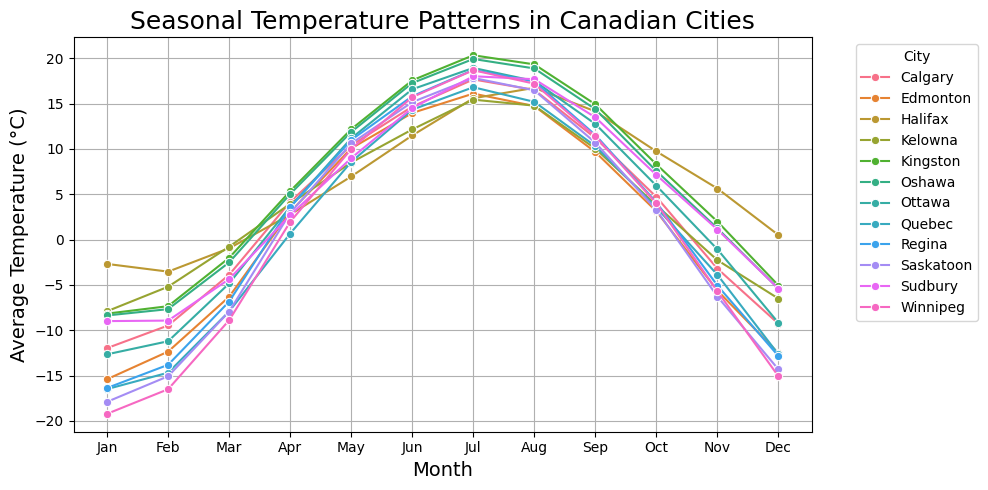

In [15]:
# Prepare the data
def prepare_seasonal_data(city_df_can):
    # Convert Date column to datetime if not already done
    city_df_can['dt'] = pd.to_datetime(city_df_can['dt'])

    # Extract month and create a new column
    city_df_can['Month'] = city_df_can['dt'].dt.month

    # Group by Month and City, calculate mean temperature
    seasonal_temps = city_df_can.groupby(['Month', 'City'])['AverageTemperature'].mean().reset_index()

    return seasonal_temps

# Create the visualization
def plot_seasonal_temperatures(seasonal_temps):
    plt.figure(figsize=(10, 5))

    # Use Seaborn's lineplot for easier visualization
    sns.lineplot(data=seasonal_temps, x='Month', y='AverageTemperature', hue='City', marker='o')

    plt.title('Seasonal Temperature Patterns in Canadian Cities', fontsize=18)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Average Temperature (°C)', fontsize=14)

    # Set x-axis ticks to month names
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    # Adjust legend placement
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()

    return plt

# Prepare and plot the data
seasonal_temps = prepare_seasonal_data(city_df_can)
plot_seasonal_temperatures(seasonal_temps)
plt.show()

### Feature Engineering
**Feature engineering** is the process of transforming raw data into meaningful features that improve a model’s performance. In many real-world applications, carefully designed features can capture underlying patterns and relationships within the data.

In this example, we will introduce a season feature by mapping each month to a corresponding season as follows:
* Winter: December (12), January (1), February (2)
* Spring: March (3), April (4), May (5)
* Summer: June (6), July (7), August (8)
* Fall: September (9), October (10), November (11)

In [16]:
# Create a copy of the original DataFrame to avoid modifying the original data
feature_df = city_df_can.copy()

# Convert the 'dt' column to a datetime format (ensures proper date handling)
feature_df['dt'] = pd.to_datetime(feature_df['dt'])

# Extract the month from the datetime column
feature_df['Month'] = feature_df['dt'].dt.month

# Extract the year from the datetime column (useful for tracking yearly trends)
feature_df['Year'] = feature_df['dt'].dt.year

# Maps each month to its corresponding season
def get_season(month):
    season_mapping = {
        'Winter': [12, 1, 2],   # December, January, February
        'Spring': [3, 4, 5],    # March, April, May
        'Summer': [6, 7, 8],    # June, July, August
        'Fall': [9, 10, 11]     # September, October, November
    }

    # Loop through to find which season the month belongs to
    for season, months in season_mapping.items():
        if month in months:
            return season

# Apply the season mapping function to the 'Month' column
feature_df['Season'] = feature_df['Month'].map(get_season)


Now we can visualize the temperature in each city, by season.

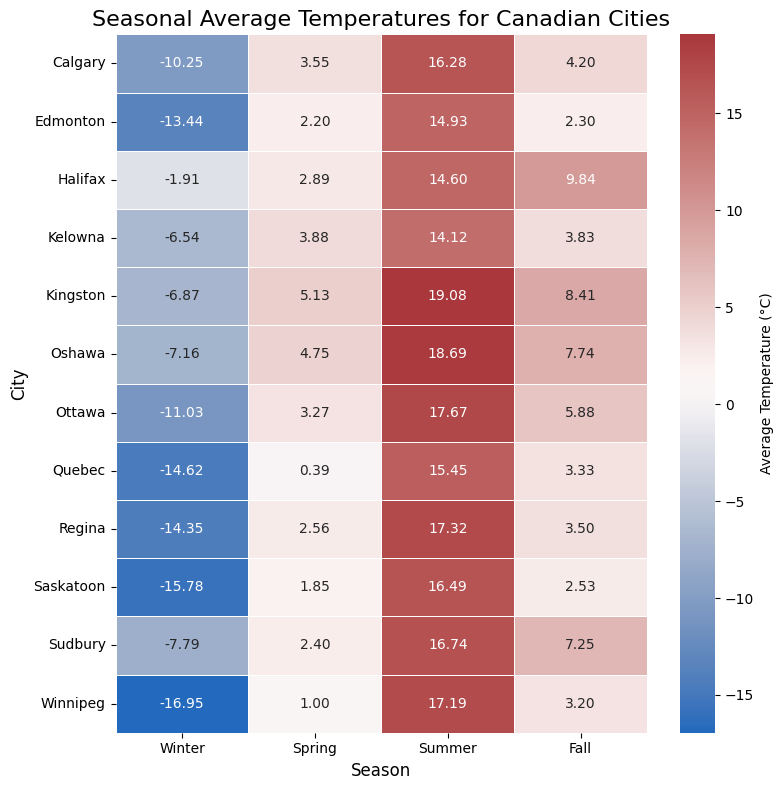

In [17]:
# Calculate average temperatures by season and city
seasonal_summary = feature_df.groupby(['City', 'Season'])['AverageTemperature'].mean().reset_index()

# Pivot the table for better readability
seasonal_pivot = seasonal_summary.pivot(index='City', columns='Season', values='AverageTemperature')

# Sort the columns in a standard seasonal order
seasonal_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_pivot = seasonal_pivot.reindex(columns=seasonal_order)

# Round the temperatures to 2 decimal places
seasonal_pivot = seasonal_pivot.round(2)

# Create the figure and plot
plt.figure(figsize=(8, 8))

# Create heatmap
sns.heatmap(seasonal_pivot,
            annot=True,  # Show the values in each cell
            cmap='vlag',  # coolwarm color palette
            fmt='.2f',  # Format to show 2 decimal places
            cbar_kws={'label': 'Average Temperature (°C)'},
            linewidths=0.5)  # Add lines between cells

plt.title('Seasonal Average Temperatures for Canadian Cities', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

We can also look at seasonal trends over time!

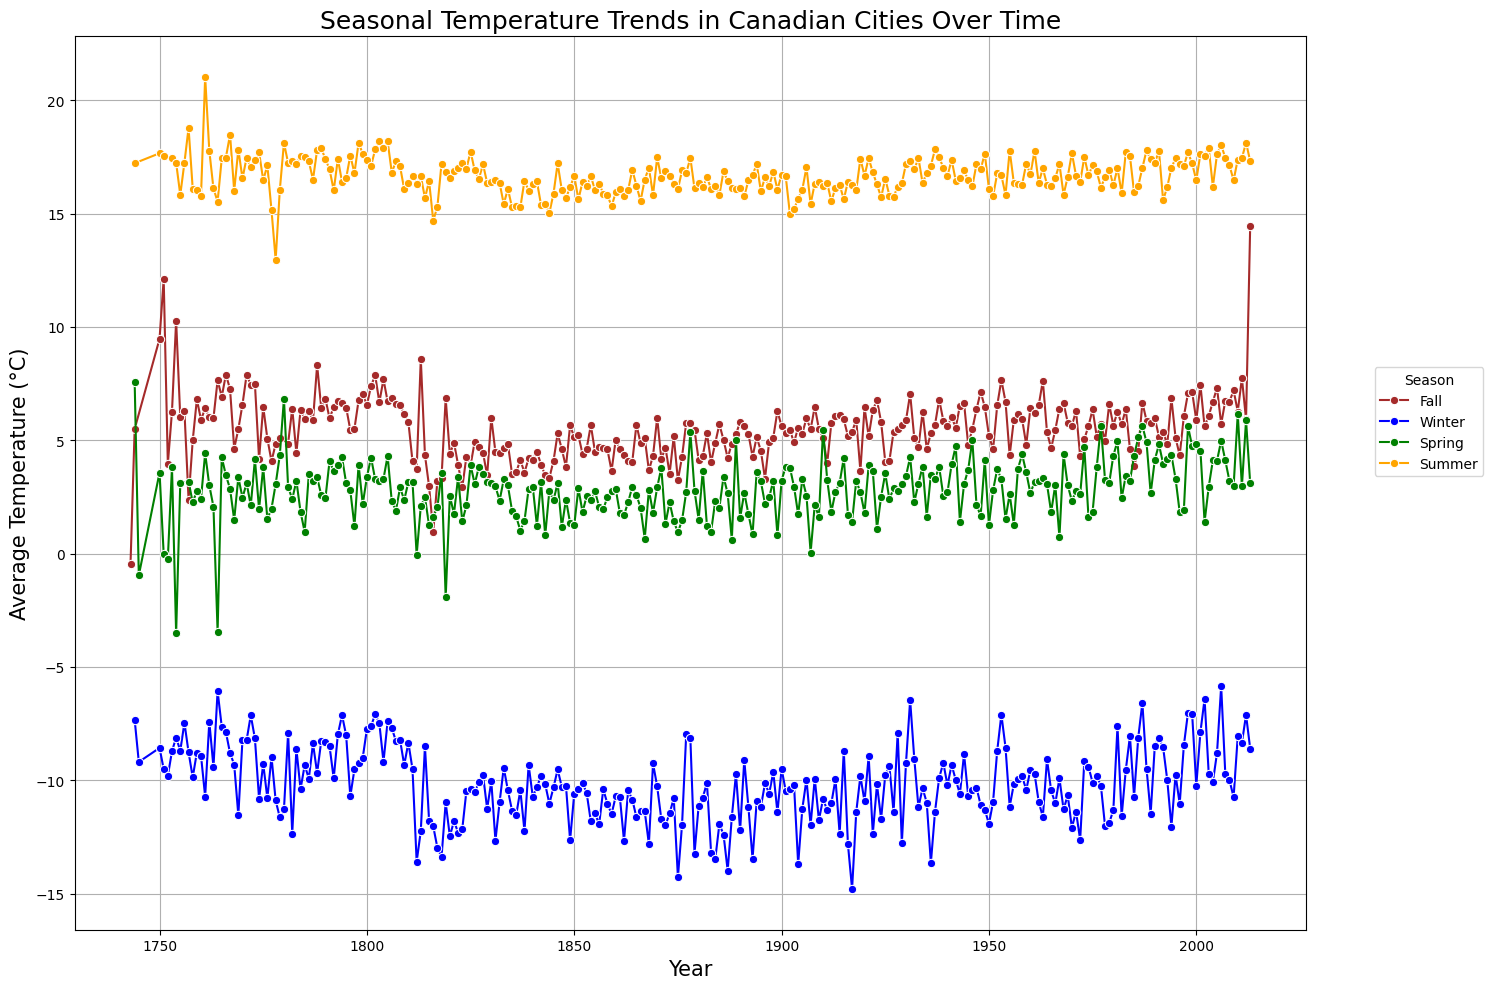

In [18]:
# Compute average temperature for each season and year
seasonal_temp_trend = feature_df.groupby(['Year', 'Season'])['AverageTemperature'].mean().reset_index()

# Set colours for each season
season_palette = {
    'Winter': 'blue',
    'Spring': 'green',
    'Summer': 'orange',
    'Fall': 'brown'
}

# Plot
plt.figure(figsize=(15, 10))
sns.lineplot(data=seasonal_temp_trend, x='Year', y='AverageTemperature', hue='Season', marker='o', palette=season_palette)
plt.title('Seasonal Temperature Trends in Canadian Cities Over Time', fontsize=18)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average Temperature (°C)', fontsize=15)
plt.legend(title='Season', bbox_to_anchor=(1.05, 0.5), loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 3: Training an AI Model

First we need to process our data  by following these steps:
1.  Separate out the year, month, and day from our `dt` column (YYYY-MM-DD).
2. Convert strings (words) to numbers, so they can be handled by machine learning models.  

In [19]:
# Read data from a csv file
city_df = pd.read_csv('/content/canada-temperature/GlobalLandTemperaturesByCity.csv')

# Choose cities where Country is Canada
city_df_can = city_df[city_df["Country"] == "Canada"]

city_df_can   # Shows a table of the data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
32382,1828-01-01,-2.763,2.617,Abbotsford,Canada,49.03N,122.45W
32383,1828-02-01,0.393,1.936,Abbotsford,Canada,49.03N,122.45W
32384,1828-03-01,4.137,1.910,Abbotsford,Canada,49.03N,122.45W
32385,1828-04-01,NaN,NaN,Abbotsford,Canada,49.03N,122.45W
32386,1828-05-01,10.630,2.346,Abbotsford,Canada,49.03N,122.45W
...,...,...,...,...,...,...,...
8226978,2013-05-01,10.280,0.518,Winnipeg,Canada,50.63N,97.61W
8226979,2013-06-01,17.123,0.401,Winnipeg,Canada,50.63N,97.61W
8226980,2013-07-01,18.685,0.237,Winnipeg,Canada,50.63N,97.61W
8226981,2013-08-01,18.620,0.600,Winnipeg,Canada,50.63N,97.61W


In [20]:
city_df_can = city_df_can.copy()

# Convert 'dt' column to datetime format and handle invalid dates as NaT
city_df_can['dt'] = pd.to_datetime(city_df_can['dt'], errors='coerce')

# Drop rows with NaT values in 'dt' column after conversion
city_df_can.dropna(subset=['dt'], inplace=True)

# Extract 'Month' and 'Year' from the 'dt' column
city_df_can['Month'] = city_df_can['dt'].dt.month
city_df_can['Year'] = city_df_can['dt'].dt.year

# Drop the 'dt' column as it's no longer needed
city_df_can.drop(columns=['dt'], inplace=True)

# Function to convert latitude
def convert_latitude(x):
    if x[-1] == 'N':  # Northern Hemisphere
        return float(x[:-1])
    elif x[-1] == 'S':  # Southern Hemisphere
        return -float(x[:-1])
    return float(x)

# Function to convert longitude
def convert_longitude(x):
    if x[-1] == 'E':  # Eastern Hemisphere
        return float(x[:-1])
    elif x[-1] == 'W':  # Western Hemisphere
        return -float(x[:-1])
    return float(x)

# Apply conversion functions to Latitude and Longitude
city_df_can['Latitude'] = city_df_can['Latitude'].apply(convert_latitude)
city_df_can['Longitude'] = city_df_can['Longitude'].apply(convert_longitude)

# Drop rows with NaN
city_df_can.dropna(inplace=True)


In [21]:
# One-hot encode the 'City' column
X = pd.get_dummies(city_df_can, columns=['City', 'Country'], drop_first=True)

# Now, 'data_encoded' contains the one-hot encoded 'City' columns,
# and the original 'City' column is replaced by separate columns for each city
X

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Month,Year,City_Barrie,City_Calgary,City_Edmonton,City_Guelph,...,City_Regina,City_Saskatoon,City_Sherbrooke,City_Sudbury,City_Toronto,City_Trois Rivières,City_Vancouver,City_Victoria,City_Waterloo,City_Winnipeg
32382,-2.763,2.617,49.03,-122.45,1,1828,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32383,0.393,1.936,49.03,-122.45,2,1828,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32384,4.137,1.910,49.03,-122.45,3,1828,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32386,10.630,2.346,49.03,-122.45,5,1828,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32387,14.425,1.939,49.03,-122.45,6,1828,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8226978,10.280,0.518,50.63,-97.61,5,2013,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8226979,17.123,0.401,50.63,-97.61,6,2013,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8226980,18.685,0.237,50.63,-97.61,7,2013,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8226981,18.620,0.600,50.63,-97.61,8,2013,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Next we can split out data into train and test sets.



In [22]:
# Define feature matrix X by dropping the 'AverageTemperature' column
X = X.drop(columns=['AverageTemperature'])
y = city_df_can['AverageTemperature']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,AverageTemperatureUncertainty,Latitude,Longitude,Month,Year,City_Barrie,City_Calgary,City_Edmonton,City_Guelph,City_Halifax,...,City_Regina,City_Saskatoon,City_Sherbrooke,City_Sudbury,City_Toronto,City_Trois Rivières,City_Vancouver,City_Victoria,City_Waterloo,City_Winnipeg
7205356,0.316,45.81,-81.92,12,1941,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5527002,2.616,44.20,-78.26,4,1835,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4331367,1.257,42.59,-80.73,7,1823,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6163324,0.501,47.42,-72.24,2,1925,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4919231,0.777,45.81,-72.69,6,1857,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5528757,0.351,44.20,-78.26,7,1981,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1305827,1.722,50.63,-112.82,1,1884,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7205951,0.235,45.81,-81.92,7,1991,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
33289,0.382,49.03,-122.45,8,1903,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Next we train a machine learning model.

But first, we need to figure out what *type* of problem we are solving.

Predicting average temperature is a **regression problem** because the target variable (temperature) is continuous and numerical, not categorical.

Temperature values can take any real number (e.g., 22.5°C, 15.3°C, -2.8°C), unlike classification problems, which predict discrete categories (e.g., "hot" or "cold").

If the goal was to classify days as "hot" vs. "cold", that would be a classification problem. Since we want a precise numerical prediction, regression is the correct choice.


In [23]:
# Train a decision tree model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

Next we can make predictions based on the test set an evaluate the performance of our model.

When evaluating our regression model, we want to measure how far our predictions are from the actual values. To do this, we can use **Mean Absolute Error (MAE)**, which measures how far off predictions are from the actual values, on average. It simply calculates the absolute differences between predicted and actual values and averages them.

**Mean Squared Error** (MSE) and **Root Mean Squared Error** (RMSE) are two other common metrics used for this purpose.

MSE calculates the average squared difference between predicted and actual values. Since errors are squared, large mistakes get penalized more heavily than small ones. This makes MSE useful when you want to focus on big errors and prevent extreme predictions.

RSME is just the square root of MSE, which brings the error back to the same unit as the target variable.  This makes RMSE easier to interpret, as it directly tells you how far off your predictions are on average. Like MSE, RMSE still penalizes larger errors more than smaller ones, but it’s more human-readable.


Mean Absolute Error: 0.89°C


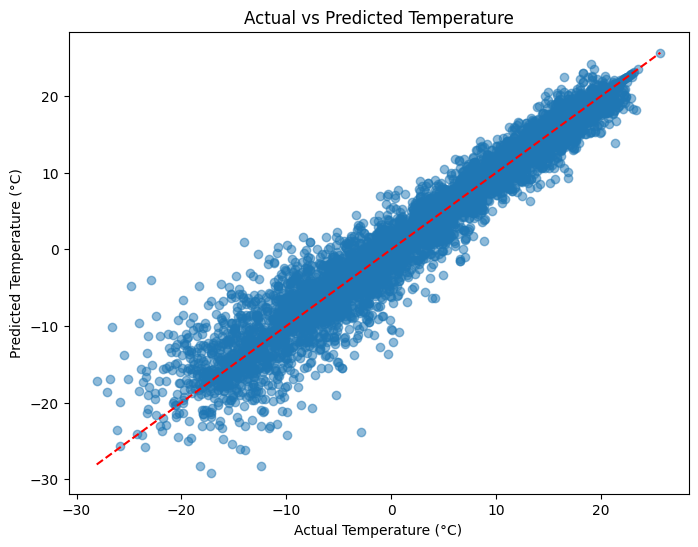

In [24]:
# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}°C")

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit")
plt.title("Actual vs Predicted Temperature")
plt.show()

This red dashed line represents perfect performance, where predicted values equal actual values. If the model performs well, the scatter points should align closely with this line.

So, our model does an okay job, but it could be better!

Try out some different models and see how well they perform on the data!

Hint: you can copy and paste the code cells above and change the name of the `model`.

In [25]:
# How would a Support Vector Machine do?
# from sklearn.svm import SVR
# model = SVR()

In [26]:
# How would a K-nearest neighbours regression model work?
# from sklearn.neighbors import KNeighborsRegressor
# model = KNeighborsRegressor()

In [27]:
# How does the performance change when you use MSE or RMSE instead of MAE?

# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_test, y_pred)

# Hint RMSE is the squareroot of MSE
# rmse = np.sqrt(mse)
